In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

%matplotlib inline

## MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


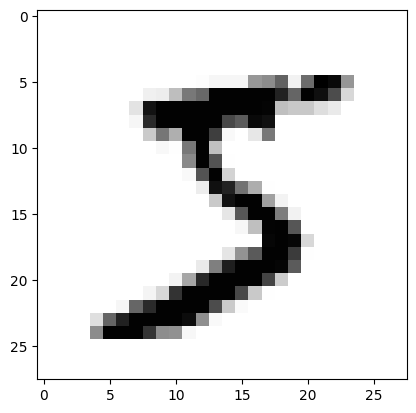

In [3]:
_ = plt.imshow(X_train[0], cmap='Greys')

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Filtering out the Data for Faster Training on Smaller Dataset

We are going to keep only the data that correspond to hand-written zeros. Zero is represented with a very distinct shape, thus making it easier for us to assess and visualize how close are the generated images to the real thing.

In [5]:
is_zero = y_train == 0

X_train = X_train[is_zero]
y_train = y_train[is_zero]

print(X_train.shape, y_train.shape)

(5923, 28, 28) (5923,)


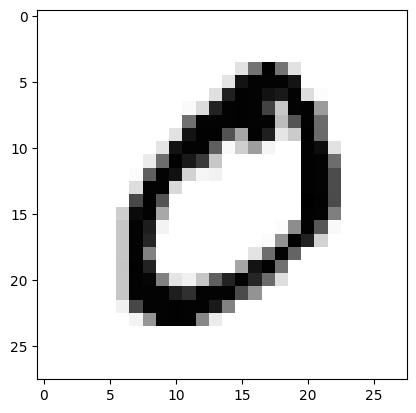

In [6]:
_ = plt.imshow(X_train[0], cmap='Greys')

## Creating a Generative Adversarial Network Model

In [7]:
# For reproducibility
tf.random.set_seed(42)

codings_size = 100

In [8]:
generator = Sequential()

generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [9]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [10]:
GAN = Sequential([generator, discriminator])

discriminator.trainable = False

GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [11]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            143634    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 132951    
                                                                 
Total params: 276585 (1.06 MB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


We can tell that our GAN consists of a generator model and a discriminator model using the ``layers`` attribute.

In [12]:
GAN.layers

In [13]:
GAN.layers[0].summary() # This is the generator

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143634 (561.07 KB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
GAN.layers[1].summary() # This is the discriminator

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 150)               117750    
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132951 (519.34 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


## Setting up Training Batches

In [15]:
batch_size = 32

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)

In [17]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [18]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
epochs = 1

## Training Loop

**NOTE**: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can begin to make progress in learning how to generate fake images, in our case, fake zeros.

In [20]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0

    # For every batch in the dataset
    for X_batch in dataset:
        i += 1
        if i%10 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")


        #####################################
        ##   TRAINING THE DISCRIMINATOR    ##
        #####################################

        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # This gets rid of a Keras warning
        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)


        #####################################
        ##     TRAINING THE GENERATOR      ##
        #####################################

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        # Avois a warning
        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185
	Currently on batch number 90 of 185
	Currently on batch number 100 of 185
	Currently on batch number 110 of 185
	Currently on batch number 120 of 185
	Currently on batch number 130 of 185
	Currently on batch number 140 of 185
	Currently on batch number 150 of 185
	Currently on batch number 160 of 185
	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
TRAINING COMPLETE


Let's test how good is the generator in generating fake zeros from noise.

In [21]:
noise = tf.random.normal(shape=[10, codings_size])

print(noise.shape)

(10, 100)


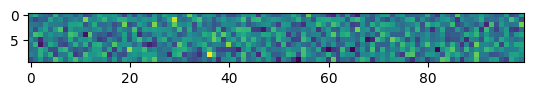

In [22]:
_ = plt.imshow(noise)

In [23]:
fake_zeros = generator(noise)

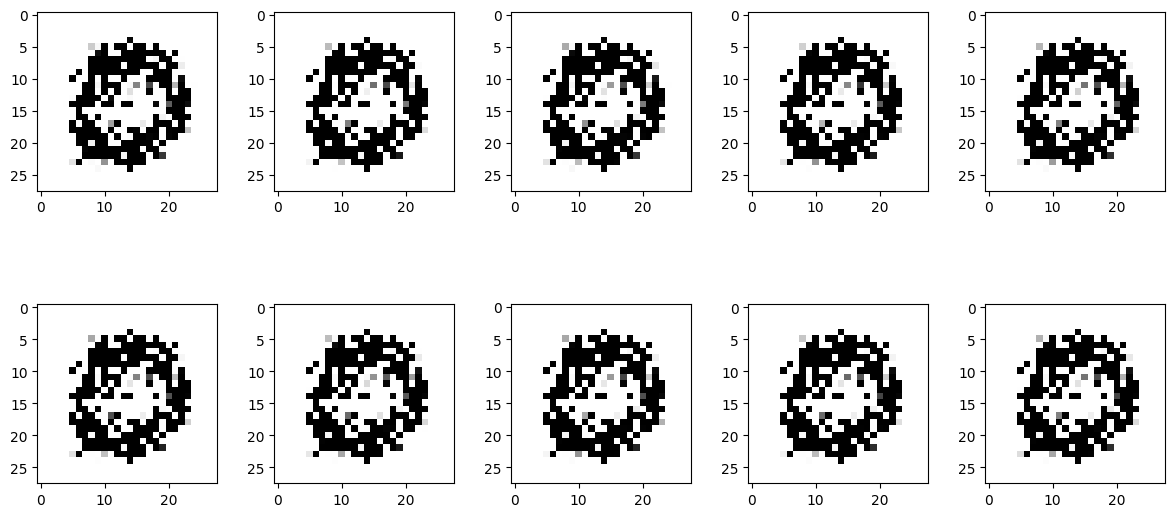

In [25]:
fig, ax = plt.subplots(2,5, figsize=(12,6))
fig.tight_layout()

idx = 0
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(fake_zeros[idx], cmap='Greys')
    idx += 1

We see that the generator produces always the same zero (with only sublte diffrences in the color value of some pixels). That's because of mode collapse. The generator "learnt" which zero always fools the discriminator and it didn't bother learning any other kind of zeros.